# Domain Background

After centuries of intense whaling, recovering whale populations still have a hard time adapting to warming oceans and struggle to compete every day with the industrial fishing industry for food.
To aid whale conservation efforts, scientists use photo surveillance systems to monitor ocean activity. They use the shape of whales’ tails and unique markings found in footage to identify what species of whale they’re analyzing and meticulously log whale pod dynamics and movements. For the past 40 years, most of this work has been done manually by individual scientists, leaving a huge trove of data untapped and underutilized.
There have been research done on identifying a whale using photos, which uses whale pictures which is similar to this effort, just that it uses the actual whale pictures.
I chose this dataset as it looked interesting and it allowed me to focus more on the deep-learning techniques, and my interest in image classification.  The challenge is to identify individual whales in images given the image of its tail fin. We will analyze Happywhale’s database of over 25,000 images, gathered from research institutions and public contributors.


# Download the kaggle data set.

Download the dataset from Kaggle, by following these steps to install [Kaggle API]: https://github.com/Kaggle/kaggle-api.  Once the kaggle api is installed, do the following.

* cd humpback-whale
* kaggle competitions download -c humpback-whale-identification
* mkdir -p input
* unzip -d input/train train.zip

In [0]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c humpback-whale-identification 
# !rm -rf input
# !mkdir -p input 
# !unzip -q -d input/train train.zip
# !unzip -q -d images test_images.zip

# Import python packages

In [2]:
import numpy as np 
import pandas as pd 
import os
import shutil
import gc
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split


from keras import layers
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications import InceptionV3, VGG19
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

%matplotlib inline

Using TensorFlow backend.


# Defining Global Constants

In [0]:
image_height=100
image_width=150
batch_size=100

# Common utility methods

In [0]:
def load_image(image_name, dir="input/train/"):
    
    #load images into images of size 100X100X3
    img = image.load_img(dir + image_name, target_size=(image_height, image_width, 3))
    x = image.img_to_array(img)
    return x
    
    
def prepare_images(data):
    print("Preparing images")
    images = np.zeros((len(data),image_height , image_width, 3))
    count = 0
    
    for fig in data.Image:
        images[count] = preprocess_input(load_image(fig))
        if (count%1000 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    count = 0
    print("Finished!")      
    return images


def display_image(image_path, dir="input/train"):
    fig=plt.figure(figsize=(5, 3))
    img = read_image(image_path, dir)
    plt.imshow(img)
    plt.show()
    
    
def read_image(file_name, dir="input/train"):
    return cv2.imread(f'{dir}/{file_name}')
    
def display_images(df, columns=3, rows=3):
    fig=plt.figure(figsize=(5*columns, 3*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'Image']
        image_id = df.loc[i,'Id']
        img = read_image(image_path)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
        

def build_pred_array(pred):
    predictions=[]
    for i, p in enumerate(pred):
        predictions.append(le.inverse_transform(p.argsort()[-5:][::-1]).tolist())
    return predictions

def remove_file(file_name):
    os.remove(file_name) if os.path.exists(file_name) else None

# Utility methods to build bottleneck features.

In [0]:
def get_steps_size(generator, batch_size):
    nb_samples = len(generator.filenames) 
    return int(math.ceil(nb_samples / batch_size))

def build_bottleneck_features(model):
    train_datagen = image.ImageDataGenerator(rescale=1. / 255)

    generator = train_datagen.flow_from_dataframe(dataframe=X_train,
                                                  directory='input/train',
                                                  x_col="Image",
                                                  y_col="Id",
                                                  classes=classes,
                                                  target_size=(image_height, image_width),
                                                  batch_size=batch_size, shuffle=False, drop_duplicates=False)

    train_bc_features = model.predict_generator(generator, steps=get_steps_size(generator, batch_size), verbose=1)

    test_datagen = image.ImageDataGenerator(rescale=1. / 255)
    generator = test_datagen.flow_from_dataframe(dataframe=X_val,
                                                 directory='input/train',
                                                 x_col="Image",
                                                 y_col="Id",
                                                 classes=classes,
                                                 target_size=(image_height, image_width),
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 drop_duplicates=False)
    val_bc_features = model.predict_generator(generator, steps=get_steps_size(generator, batch_size), verbose=1)

    generator = test_datagen.flow_from_dataframe(dataframe=X_test,
                                                 directory='input/train',
                                                 x_col="Image",
                                                 y_col="Id",
                                                 classes=classes,
                                                 target_size=(image_height, image_width),
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 drop_duplicates=False)
    test_bc_features = model.predict_generator(generator, steps=get_steps_size(generator, batch_size), verbose=1)
    return train_bc_features, val_bc_features, test_bc_features

# Explore the training data.


## Load dataset

In [6]:
train_df = pd.read_csv("train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [7]:
print('Number of rows in train.csv', len(train_df))

Number of rows in train.csv 25361


In [8]:
print('Number of unique whale Id' ,len(train_df.Id.value_counts()))

Number of unique whale Id 5005


## Identify the data points

### train.csv
There are 25361 rows in train.csv.  Which corresponds to the image entries in train.zip
We can see that the train.csv file has two data fields.  
* Image : The whale image file name
* Id is the whale Id.
Each whale is assigned a unique Id.  The unidentified whale's are assigned an Id new_whale.  


### train.zip
There are 25361 image files in train.zip.  It has been extracted to input/train folder.  The filename corresponds to the Image column in train.csv file.

### test.zip

In this kaggle dataset, it has train.csv, train.zip and test.zip.  But for the scope of this project, I decided not to use test.zip (as there is no way to validate the results).  I will use the train.csv and train.zip (train folder after extracting the archive to a folder) and split it into training, validation and test datasets.


## Display sample images

Let us display a few of the whale images.  The following diagram shows around 9 whales and its Id. 

26

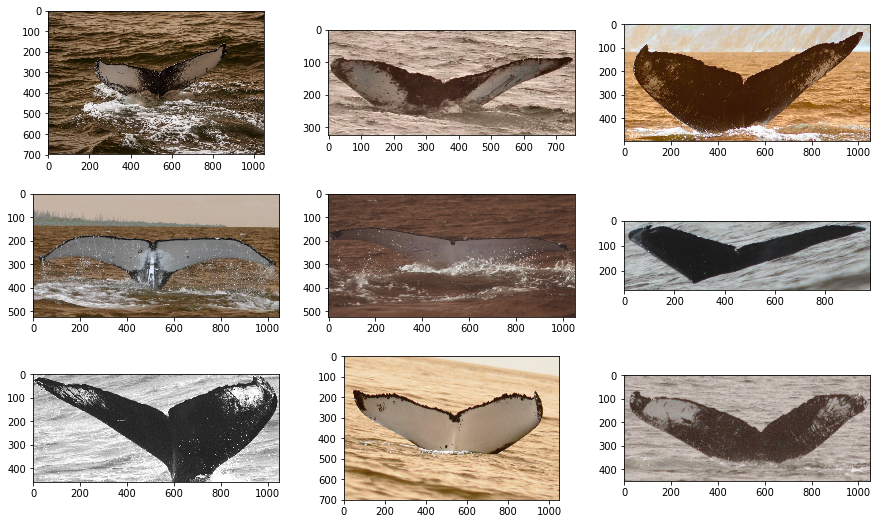

In [9]:
display_images(train_df)
gc.collect()

## Whale Id class distribution
* From the class distribution we can see that new_whale has around 9664 entries.

In [10]:
labels_count = train_df.Id.value_counts()
labels_count.head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [11]:
labels_count.describe()

count    5005.000000
mean        5.067133
std       136.634756
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max      9664.000000
Name: Id, dtype: float64

In [12]:
counts = train_df.Id.value_counts()
print('Whale Id less than 5  %s entries' %(len(counts[counts < 5])))
print('Whale Id greater than 5 %d entries' %(len(counts[counts >= 5].index)))

Whale Id less than 5  4199 entries
Whale Id greater than 5 806 entries


#### Lets plot a histogram with new_whale and without new_whale.  
  
  * From the first diagram we can see that there is only one instance which has around 9000+ entries, and rest of the whale Id's are in the 0-100 range.
  * In the second histogram, I removed new_whale, and see that Removing the new_whalethat We can see that there are a whereas the rest of the whale Id's are in the range of 0-70 range.

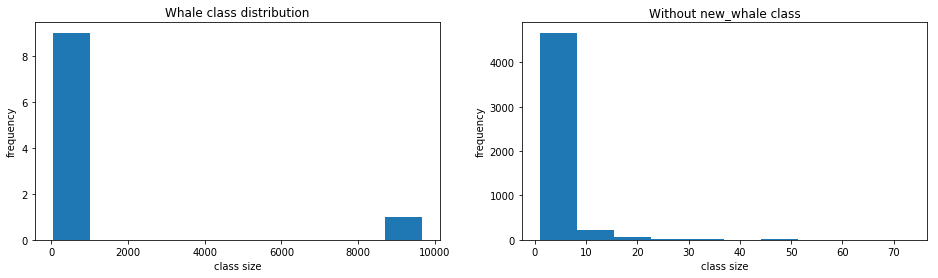

In [13]:
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.hist(labels_count.values[:10])
plt.ylabel("frequency")
plt.xlabel("class size")
plt.title('Whale class distribution')


plt.subplot(122)
plt.hist(labels_count.values[1:])
plt.ylabel("frequency")
plt.xlabel("class size")
plt.title('Without new_whale class')

plt.show()

# Data pre-processing

## Label Encoding

In [14]:
labels = train_df.Id

# Encode labels to integers using sklearning.preprocessing.LabelEncoder
# Convert the integer encoded array to category
le = LabelEncoder()
le.fit(labels)
# Number of unique labels.
num_classes = len(le.classes_)
classes = le.classes_.tolist()
print('Number of unique whales {}'.format(num_classes))


Number of unique whales 5005


## Encode the labels into categorical value
Lets transform label data into categorical data that will be used in our CNN models 

In [0]:
y_transform = np_utils.to_categorical(le.transform(labels), num_classes=num_classes)

## Split the data into training, validation & test datasets

In [16]:
X_train, X_tmp, Y_train, Y_tmp = train_test_split(train_df, y_transform, test_size=0.2, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_tmp, Y_tmp, test_size=0.5, random_state=5)

print('Training, Validation & testing data size', len(X_train),len(X_val), len(X_test))
print(len(X_train.Id.value_counts()))
gc.collect()

Training, Validation & testing data size 20288 2536 2537
4555


23126

# Create a Base CNN  model

## Prepare Images
Lets prepare the images for training, validation and testing, so that we can run the CNN model we created from scratch

In [17]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

x_train_images = prepare_images(X_train)
x_train_images /= 255

print("Shape X-train: ", x_train_images.shape)

x_val_images = prepare_images(X_val)
x_val_images /= 255

print("Shape X-val: ", x_val_images.shape)

x_test_images = prepare_images(X_test)
x_test_images /= 255

print("Shape X-test: ", x_test_images.shape)

Preparing images
Processing image:  1 ,  5e2572252.jpg
Processing image:  1001 ,  942ab5de3.jpg
Processing image:  2001 ,  614f10ee7.jpg
Processing image:  3001 ,  86c9aa515.jpg
Processing image:  4001 ,  6f0c3deb4.jpg
Processing image:  5001 ,  f532c9318.jpg
Processing image:  6001 ,  6ca37fe7c.jpg
Processing image:  7001 ,  feddb3aa9.jpg
Processing image:  8001 ,  16ddf58df.jpg
Processing image:  9001 ,  c2a02f80e.jpg
Processing image:  10001 ,  803515118.jpg
Processing image:  11001 ,  5f37d323c.jpg
Processing image:  12001 ,  27fdfe88c.jpg
Processing image:  13001 ,  a7505ae38.jpg
Processing image:  14001 ,  788a2531c.jpg
Processing image:  15001 ,  a61a7cbf1.jpg
Processing image:  16001 ,  f842d2d41.jpg
Processing image:  17001 ,  38b192e64.jpg
Processing image:  18001 ,  898201c7f.jpg
Processing image:  19001 ,  f5cfbf2df.jpg
Processing image:  20001 ,  a3785aebd.jpg
Finished!
Shape X-train:  (20288, 100, 150, 3)
Preparing images
Processing image:  1 ,  f6992fe3c.jpg
Processing i

## Build Model

In [18]:
base_model = Sequential()

base_model.add(Conv2D(filters = 16, kernel_size = 3,  padding = 'same', 
                      activation = 'relu',
                      input_shape = (image_height, image_width, 3)))
base_model.add(MaxPooling2D(pool_size=3))


base_model.add(Conv2D(filters = 32, kernel_size = 3,  padding = 'same', 
                      activation = 'relu'))
base_model.add(BatchNormalization())
base_model.add(MaxPooling2D(pool_size=3))
base_model.add(Dropout(0.25))

base_model.add(Conv2D(filters = 64, kernel_size = 3,  padding = 'same', 
                      activation = 'relu'))
base_model.add(AveragePooling2D())
base_model.add(Dropout(0.25))

base_model.add(Flatten())
base_model.add(Dense(512, activation='relu'))
base_model.add(Dropout(0.5))

base_model.add(Dense(num_classes, activation='softmax'))

base_model.summary()

W0726 01:33:27.987729 139798252324736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 01:33:28.001326 139798252324736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 01:33:28.004544 139798252324736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 01:33:28.021704 139798252324736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0726 01:33:28.051602 139798252324736 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 150, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 50, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 50, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 16, 64)        18496     
__________

## Compile Model

In [19]:
from keras.metrics import top_k_categorical_accuracy

def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)


base_model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['categorical_accuracy', top_5_accuracy])


W0726 01:33:28.830031 139798252324736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Train the Model

In [20]:
os.makedirs('saved_models', exist_ok=True)
gc.collect()

0

In [21]:
BASE_CNN_MODEL='saved_models/weight.best.from_scratch.hdf5'
remove_file(BASE_CNN_MODEL)

checkpointer = ModelCheckpoint(filepath=BASE_CNN_MODEL, 
                               save_best_only = True, verbose=1)

history = base_model.fit(x_train_images, Y_train, epochs=100, batch_size=batch_size,
          validation_data=(x_val_images, Y_val), 
          callbacks=[checkpointer])
gc.collect()


W0726 01:33:29.108104 139798252324736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20288 samples, validate on 2536 samples
Epoch 1/100
20288/20288 [==============================] - 18s 893us/step - loss: 6.0203 - categorical_accuracy: 0.3799 - top_5_accuracy: 0.3879 - val_loss: 5.8315 - val_categorical_accuracy: 0.3825 - val_top_5_accuracy: 0.3955

Epoch 00001: val_loss improved from inf to 5.83148, saving model to saved_models/weight.best.from_scratch.hdf5
Epoch 2/100
20288/20288 [==============================] - 16s 783us/step - loss: 5.7135 - categorical_accuracy: 0.3815 - top_5_accuracy: 0.3947 - val_loss: 5.8229 - val_categorical_accuracy: 0.3825 - val_top_5_accuracy: 0.3987

Epoch 00002: val_loss improved from 5.83148 to 5.82293, saving model to saved_models/weight.best.from_scratch.hdf5
Epoch 3/100
20288/20288 [==============================] - 16s 781us/step - loss: 5.5989 - categorical_accuracy: 0.3815 - top_5_accuracy: 0.3982 - val_loss: 5.8069 - val_categorical_accuracy: 0.3825 - val_top_5_accuracy: 0.4006

Epoch 00003: val_loss improved from 5.

100

## Test the Model

In [22]:
base_model.load_weights(BASE_CNN_MODEL)
base_pred = base_model.predict(x_test_images, verbose=1)
print(base_pred.shape)


(eval_loss, cat_accuracy,top5accuracy) = base_model.evaluate(  
     x_val_images, Y_val, batch_size=batch_size, verbose=1)

print("[INFO] Categorical accuracy: {:.2f}%".format(cat_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss)) 
print("[INFO] Top 5 accuracy: {:.2f}%".format(top5accuracy * 100))

2537/2537 [==============================] - 1s 491us/step
(2537, 5005)
2536/2536 [==============================] - 1s 462us/step
[INFO] Categorical accuracy: 38.25%
[INFO] Loss: 5.6748852970472266
[INFO] Top 5 accuracy: 41.80%


## MAP@5 for Base CNN Model

In [23]:
import map5_score as map5
print('MAP@5 score for Base model = %.5f' %(map5.map5_per_set(X_test.Id, build_pred_array(base_pred) )))

MAP@5 score for Base model = 0.38923


## MAP@5 For Individual Images for CNN

In [0]:
def predict_cnn_labels(image_df, model):
    print('Predicting the whale Id for %s' %(image_df.Image))
    display_image(image_df.Image)
    img = np.expand_dims(load_image(image_df.Image), axis=0)

    predicted_vector = model.predict(preprocess_input(img))
    print('Test whale Id=[%s], predicted top 5 Ids=%s' \
          %(image_df.Id, build_pred_array(predicted_vector)[0]))
    
    print('MAP@5 score for %s model = %.5f\n' \
      %(image_df.Image, map5.map5_per_image(image_df.Id, build_pred_array(predicted_vector)[0])))

#Method to predict just images.
def predict_cnn_indiv_labels(original_label, file_name, model, dir):
    print('Predicting the whale Id for %s' %(file_name))
    display_image(file_name,dir)
    img = np.expand_dims(load_image(file_name, dir), axis=0)
    predicted_vector = model.predict(preprocess_input(img))
    print('Predicted whaleid for file=[%s] original whaleid [%s] , predicted top 5 Ids=%s\n' \
          %(file_name, original_label, build_pred_array(predicted_vector)[0]))

Predicting the whale Id for 343269bd4.jpg


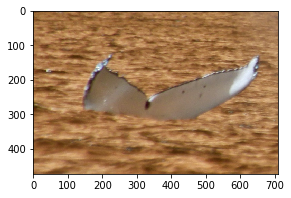

Test whale Id=[new_whale], predicted top 5 Ids=['new_whale', 'w_567502c', 'w_563d4b1', 'w_5645ed1', 'w_564a34b']
MAP@5 score for 343269bd4.jpg model = 1.00000

Predicting the whale Id for 88766032d.jpg


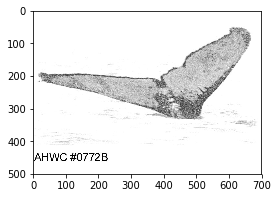

Test whale Id=[w_1106cbb], predicted top 5 Ids=['new_whale', 'w_567502c', 'w_563d4b1', 'w_5645ed1', 'w_564a34b']
MAP@5 score for 88766032d.jpg model = 0.00000

Predicting the whale Id for 88d792568.jpg


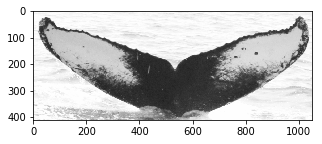

Test whale Id=[w_102821e], predicted top 5 Ids=['new_whale', 'w_567502c', 'w_563d4b1', 'w_5645ed1', 'w_564a34b']
MAP@5 score for 88d792568.jpg model = 0.00000



In [25]:
predict_cnn_labels(X_test.iloc[100], base_model)
predict_cnn_labels(X_test.iloc[500], base_model)
predict_cnn_labels(X_test.iloc[302], base_model)

## Predicting Whale Id with Gaussian noise added. (Base Model)

Predicting the whale Id for 3131fb73b.jpg


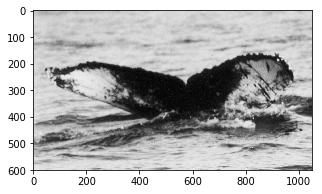

Predicted whaleid for file=[3131fb73b.jpg] original whaleid [new_whale] , predicted top 5 Ids=['new_whale', 'w_567502c', 'w_563d4b1', 'w_5645ed1', 'w_564a34b']

Predicting the whale Id for 3131fb73b_noisedimage.jpg


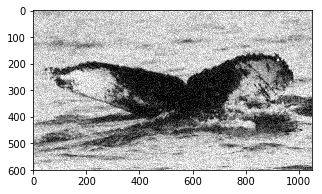

Predicted whaleid for file=[3131fb73b_noisedimage.jpg] original whaleid [new_whale] , predicted top 5 Ids=['new_whale', 'w_567502c', 'w_563d4b1', 'w_5645ed1', 'w_564a34b']

Predicting the whale Id for eeddcd5ce.jpg


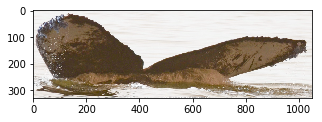

Predicted whaleid for file=[eeddcd5ce.jpg] original whaleid [w_f6032e9] , predicted top 5 Ids=['new_whale', 'w_567502c', 'w_563d4b1', 'w_5645ed1', 'w_564a34b']

Predicting the whale Id for 32774657f_noisedimage.jpg


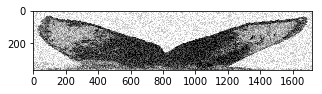

Predicted whaleid for file=[32774657f_noisedimage.jpg] original whaleid [w_f6032e9] , predicted top 5 Ids=['new_whale', 'w_567502c', 'w_563d4b1', 'w_5645ed1', 'w_564a34b']



In [26]:
predict_cnn_indiv_labels('new_whale', '3131fb73b.jpg', base_model, 'input/train/')
predict_cnn_indiv_labels('new_whale', '3131fb73b_noisedimage.jpg', base_model, 'images/')

predict_cnn_indiv_labels('w_f6032e9', 'eeddcd5ce.jpg' , base_model, 'input/train/')
predict_cnn_indiv_labels('w_f6032e9', '32774657f_noisedimage.jpg', base_model, 'images/')

## Training Accuracy

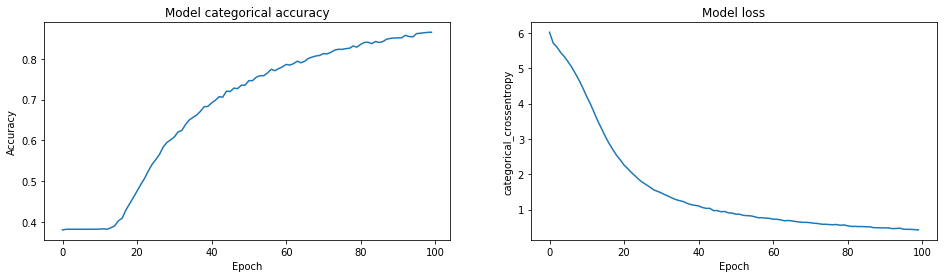

In [27]:
def plot_training_history(history):
    plt.figure(figsize=(16, 4))
    plt.subplot(121)
    plt.plot(history.history['categorical_accuracy'])
    plt.title('Model categorical accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('categorical_crossentropy')
    plt.xlabel('Epoch')
    plt.show()
    
plot_training_history(history)

# Using VGG19 and Transfer learning

We will use VGG19 to train the whale images using bottleneck features and transfer learning.  The advantage here is that we can train a CNN much quicker by reducing the training time.



## Build bottleneck features


In [28]:
vggtrain_features, vggval_features, vggtest_features = build_bottleneck_features(VGG19(include_top=False, weights='imagenet'))
gc.collect()

Found 20288 validated image filenames belonging to 5005 classes.
203/203 [==============================] - 195s 960ms/step
Found 2536 validated image filenames belonging to 5005 classes.
26/26 [==============================] - 26s 998ms/step
Found 2537 validated image filenames belonging to 5005 classes.
26/26 [==============================] - 26s 993ms/step


19175

## Build the Model

In [29]:
print(vggtest_features.shape)

vgg_model = Sequential()  
vgg_model.add(Dense(1024, activation='relu', input_shape=vggtest_features.shape[1:]))  
vgg_model.add(Dropout(0.25))
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dropout(0.5))

vgg_model.add(Dense(num_classes, activation='softmax')) 

vgg_model.summary()

(2537, 3, 4, 512)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3, 4, 1024)        525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 4, 1024)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5005)              5130125   
Total params: 5,655,437
Trainable params: 5,655,437
Non-trainable params: 0
_________________________________________________________________


## Compile the Model

In [0]:
vgg_model.compile(optimizer='adam',  
              loss='categorical_crossentropy', metrics=['categorical_accuracy',top_5_accuracy])

## Train the Model

In [31]:
VGG_BOTTLE_NECK_MODEL='saved_models/bottleneck_fc_model.hdf5'
remove_file(VGG_BOTTLE_NECK_MODEL)

checkpointer = ModelCheckpoint(filepath=VGG_BOTTLE_NECK_MODEL,
                               verbose=1, save_best_only = True)

history = vgg_model.fit(vggtrain_features, Y_train,  
          epochs=100,  
          batch_size=batch_size,  
          validation_data=(vggval_features, Y_val), callbacks=[checkpointer], verbose=1)  
   
gc.collect()

Train on 20288 samples, validate on 2536 samples
Epoch 1/100
20288/20288 [==============================] - 5s 243us/step - loss: 5.9839 - categorical_accuracy: 0.3781 - top_5_accuracy: 0.3869 - val_loss: 5.7781 - val_categorical_accuracy: 0.3825 - val_top_5_accuracy: 0.3927

Epoch 00001: val_loss improved from inf to 5.77805, saving model to saved_models/bottleneck_fc_model.hdf5
Epoch 2/100
20288/20288 [==============================] - 4s 213us/step - loss: 5.6293 - categorical_accuracy: 0.3815 - top_5_accuracy: 0.3967 - val_loss: 5.7645 - val_categorical_accuracy: 0.3825 - val_top_5_accuracy: 0.3983

Epoch 00002: val_loss improved from 5.77805 to 5.76450, saving model to saved_models/bottleneck_fc_model.hdf5
Epoch 3/100
20288/20288 [==============================] - 4s 219us/step - loss: 5.4535 - categorical_accuracy: 0.3815 - top_5_accuracy: 0.4058 - val_loss: 5.7567 - val_categorical_accuracy: 0.3825 - val_top_5_accuracy: 0.4054

Epoch 00003: val_loss improved from 5.76450 to 5.75

180

## Test the Model

In [32]:
vgg_model.load_weights(VGG_BOTTLE_NECK_MODEL)
vggpred = vgg_model.predict(vggtest_features, verbose=1)

(eval_loss, cat_accuracy,top5accuracy) = vgg_model.evaluate(  
     vggval_features, Y_val, batch_size=batch_size, verbose=1)

print("[INFO] Categorical accuracy: {:.2f}%".format(cat_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss)) 
print("[INFO] Top 5 accuracy: {:.2f}%".format(top5accuracy * 100))

2536/2536 [==============================] - 0s 80us/step
[INFO] Categorical accuracy: 38.25%
[INFO] Loss: 5.711272605210072
[INFO] Top 5 accuracy: 41.80%


## MAP@5 for VGG19  Model

In [33]:
print('MAP@5 score for VGG19 model = %.5f' %(map5.map5_per_set(X_test.Id,  build_pred_array(vggpred) )))

MAP@5 score for VGG19 model = 0.38766


## Predict individual images using VGG19

In [0]:
from extract_bottleneck_features import *

def predict_labels(image_df, extract_bc_func, model):
    print('Predicting the whale Id for %s' %(image_df.Image))
    display_image(image_df.Image)
    img = np.expand_dims(load_image(image_df.Image), axis=0)
    bottleneck_feature = extract_bc_func(img)
    predicted_vector = model.predict(bottleneck_feature)
    print('Test whale Id=[%s], predicted top 5 Ids=%s' \
          %(image_df.Id, build_pred_array(predicted_vector)[0]))
    
    print('MAP@5 score for %s model = %.5f\n' \
      %(image_df.Image, map5.map5_per_image(image_df.Id, build_pred_array(predicted_vector)[0])))

#Method to predict just images.
def predict_indiv_labels(file_name, extract_bc_func, model, dir):
    print('Predicting the whale Id for %s' %(file_name))
    display_image(file_name,dir)
    img = np.expand_dims(load_image(file_name,dir), axis=0)
    bottleneck_feature = extract_bc_func(img)
    predicted_vector = model.predict(bottleneck_feature)
    print('Predicted whaleid for file=[%s], predicted top 5 Ids=%s' \
          %(file_name, build_pred_array(predicted_vector)[0]))
    
    
def predict_vgg_labels(image_df):
    predict_labels(image_df, extract_VGG19, vgg_model)
    

Predicting the whale Id for 343269bd4.jpg


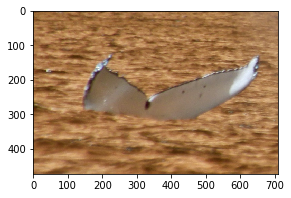

Test whale Id=[new_whale], predicted top 5 Ids=['new_whale', 'w_567502c', 'w_563d4b1', 'w_5645ed1', 'w_564a34b']
MAP@5 score for 343269bd4.jpg model = 1.00000

Predicting the whale Id for 88766032d.jpg


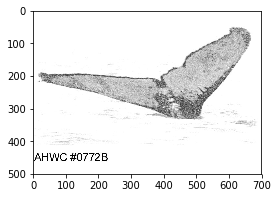

Test whale Id=[w_1106cbb], predicted top 5 Ids=['new_whale', 'w_567502c', 'w_563d4b1', 'w_5645ed1', 'w_564a34b']
MAP@5 score for 88766032d.jpg model = 0.00000

Predicting the whale Id for 88d792568.jpg


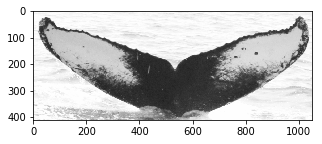

Test whale Id=[w_102821e], predicted top 5 Ids=['new_whale', 'w_343f088', 'w_5665c80', 'w_563d4b1', 'w_5645ed1']
MAP@5 score for 88d792568.jpg model = 0.00000



In [35]:
predict_vgg_labels(X_test.iloc[100])
predict_vgg_labels(X_test.iloc[500])
predict_vgg_labels(X_test.iloc[302])

## Predict an image with added gaussian noise

Predicting the whale Id for 3131fb73b.jpg


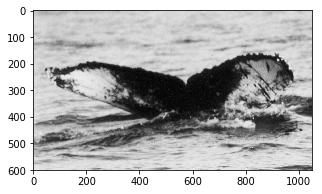

Predicted whaleid for file=[3131fb73b.jpg], predicted top 5 Ids=['new_whale', 'w_23a388d', 'w_bfcad53', 'w_9c506f6', 'w_5a2634c']
Predicting the whale Id for 3131fb73b_noisedimage.jpg


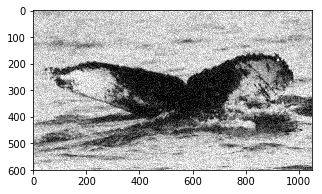

Predicted whaleid for file=[3131fb73b_noisedimage.jpg], predicted top 5 Ids=['new_whale', 'w_17b0d3a', 'w_5a2634c', 'w_bfcad53', 'w_567d88c']
Predicting the whale Id for 32774657f.jpg


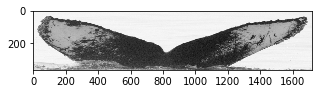

Predicted whaleid for file=[32774657f.jpg], predicted top 5 Ids=['new_whale', 'w_343f088', 'w_5a2634c', 'w_17b0d3a', 'w_e27bbf6']
Predicting the whale Id for 32774657f_noisedimage.jpg


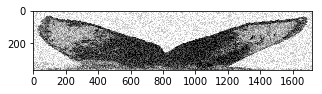

Predicted whaleid for file=[32774657f_noisedimage.jpg], predicted top 5 Ids=['new_whale', 'w_343f088', 'w_5665c80', 'w_563d4b1', 'w_5645ed1']


In [36]:
predict_indiv_labels('3131fb73b.jpg', extract_VGG19, vgg_model, 'input/train/')
predict_indiv_labels('3131fb73b_noisedimage.jpg', extract_VGG19, vgg_model, 'images/')

predict_indiv_labels('32774657f.jpg', extract_VGG19, vgg_model, 'input/train/')
predict_indiv_labels('32774657f_noisedimage.jpg', extract_VGG19, vgg_model, 'images/')


## Training Accuracy

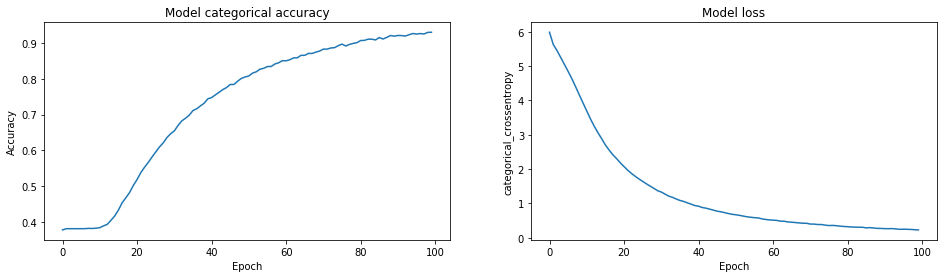

In [37]:
plot_training_history(history)

# Using InceptionV3 and Transfer learning

To reduce training time without sacrificing accuracy, lets train a CNN using transfer learning.



## Build bottleneck features

In [38]:
incptrain_features, incpval_features, incptest_features = build_bottleneck_features(InceptionV3(include_top=False, weights='imagenet'))

Found 20288 validated image filenames belonging to 5005 classes.
203/203 [==============================] - 187s 920ms/step
Found 2536 validated image filenames belonging to 5005 classes.
26/26 [==============================] - 24s 928ms/step
Found 2537 validated image filenames belonging to 5005 classes.
26/26 [==============================] - 24s 928ms/step


## Build the Model

In [39]:
print(incptrain_features.shape)
incp_model = Sequential()
incp_model.add(Dense(512, activation='relu', input_shape=incptrain_features.shape[1:]))  
incp_model.add(Dropout(0.25))
incp_model.add(GlobalAveragePooling2D())
incp_model.add(Dropout(0.5))
incp_model.add(Dense(num_classes, activation='softmax'))

incp_model.summary()

(20288, 1, 3, 2048)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1, 3, 512)         1049088   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 3, 512)         0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5005)              2567565   
Total params: 3,616,653
Trainable params: 3,616,653
Non-trainable params: 0
_________________________________________________________________


## Compile the Model

In [0]:
incp_model.compile(optimizer='adam',  
              loss='categorical_crossentropy', metrics=['categorical_accuracy',top_5_accuracy])

## Train the Model

In [41]:
INCP_BOTTLE_NECK_MODEL='saved_models/bottleneck_incp_model.hdf5'
remove_file(INCP_BOTTLE_NECK_MODEL)

checkpointer = ModelCheckpoint(filepath=INCP_BOTTLE_NECK_MODEL,
                               save_best_only = True,verbose=1)

history = incp_model.fit(incptrain_features, Y_train,  
          epochs=100,  
          batch_size=batch_size,  
          validation_data=(incpval_features, Y_val), callbacks=[checkpointer])  

gc.collect()

Train on 20288 samples, validate on 2536 samples
Epoch 1/100
20288/20288 [==============================] - 6s 272us/step - loss: 6.2933 - categorical_accuracy: 0.3798 - top_5_accuracy: 0.3901 - val_loss: 5.8971 - val_categorical_accuracy: 0.3825 - val_top_5_accuracy: 0.4010

Epoch 00001: val_loss improved from inf to 5.89711, saving model to saved_models/bottleneck_incp_model.hdf5
Epoch 2/100
20288/20288 [==============================] - 3s 169us/step - loss: 5.9350 - categorical_accuracy: 0.3815 - top_5_accuracy: 0.4002 - val_loss: 5.8165 - val_categorical_accuracy: 0.3825 - val_top_5_accuracy: 0.4113

Epoch 00002: val_loss improved from 5.89711 to 5.81645, saving model to saved_models/bottleneck_incp_model.hdf5
Epoch 3/100
20288/20288 [==============================] - 3s 170us/step - loss: 5.7449 - categorical_accuracy: 0.3813 - top_5_accuracy: 0.4079 - val_loss: 5.8501 - val_categorical_accuracy: 0.3825 - val_top_5_accuracy: 0.4125

Epoch 00003: val_loss did not improve from 5.81

454

## Test the Model

In [42]:
incp_model.load_weights(INCP_BOTTLE_NECK_MODEL)
incp_pred = incp_model.predict(incptest_features, verbose=1)

(eval_loss, eval_accuracy,top5accuracy) = incp_model.evaluate(  
     incpval_features, Y_val, batch_size=batch_size, verbose=1)

print("[INFO] Categorical accuracy: {:.2f}%".format(cat_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss)) 
print("[INFO] Top 5 accuracy: {:.2f}%".format(top5accuracy * 100))

2536/2536 [==============================] - 0s 79us/step
[INFO] Categorical accuracy: 38.25%
[INFO] Loss: 5.8164506289485125
[INFO] Top 5 accuracy: 41.13%


## MAP@5 for InceptionV3 Transfer Learning

In [43]:
print('MAP@5 score for InceptionV3 model = %.5f' %(map5.map5_per_set(X_test.Id,  build_pred_array(incp_pred))))

MAP@5 score for InceptionV3 model = 0.38385


## MAP@5 for individual images

Predicting the whale Id for 343269bd4.jpg


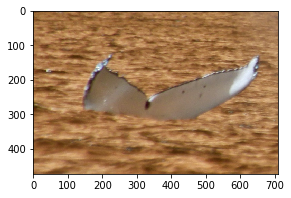

Test whale Id=[new_whale], predicted top 5 Ids=['new_whale', 'w_343f088', 'w_789c969', 'w_bc285a6', 'w_564a34b']
MAP@5 score for 343269bd4.jpg model = 1.00000

Predicting the whale Id for e12399f02.jpg


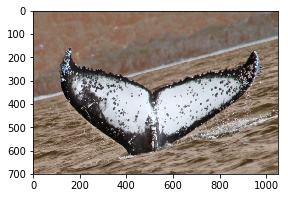

Test whale Id=[new_whale], predicted top 5 Ids=['new_whale', 'w_3de579a', 'w_bc285a6', 'w_4690940', 'w_f0fe284']
MAP@5 score for e12399f02.jpg model = 1.00000

Predicting the whale Id for 3131fb73b.jpg


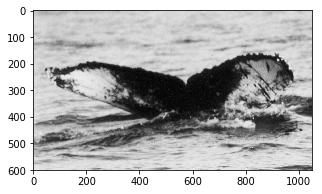

Test whale Id=[new_whale], predicted top 5 Ids=['new_whale', 'w_0369a5c', 'w_88e4537', 'w_23a388d', 'w_242fb46']
MAP@5 score for 3131fb73b.jpg model = 1.00000

Predicting the whale Id for 88d792568.jpg


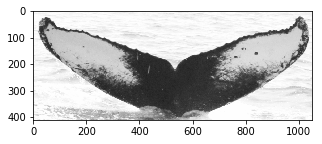

Test whale Id=[w_102821e], predicted top 5 Ids=['new_whale', 'w_e07b79f', 'w_5773c71', 'w_0369a5c', 'w_d405854']
MAP@5 score for 88d792568.jpg model = 0.00000



In [44]:
from extract_bottleneck_features import *

def predict_incp_labels(image_df):
    predict_labels(image_df, extract_InceptionV3, incp_model)
    

predict_incp_labels(X_test.iloc[100])
predict_incp_labels(X_test.iloc[1400])
predict_incp_labels(X_test.iloc[300])
predict_incp_labels(X_test.iloc[302])

## Predict an image's class original and one with added gaussian noise

Predicting the whale Id for 3131fb73b.jpg


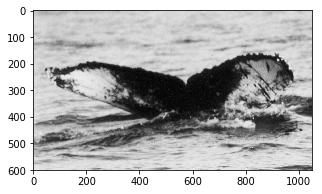

Predicted whaleid for file=[3131fb73b.jpg], predicted top 5 Ids=['new_whale', 'w_0369a5c', 'w_88e4537', 'w_23a388d', 'w_242fb46']
Predicting the whale Id for 3131fb73b_noisedimage.jpg


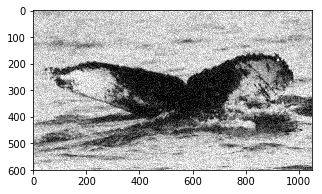

Predicted whaleid for file=[3131fb73b_noisedimage.jpg], predicted top 5 Ids=['new_whale', 'w_23a388d', 'w_5a2634c', 'w_9c506f6', 'w_0369a5c']
Predicting the whale Id for 32774657f.jpg


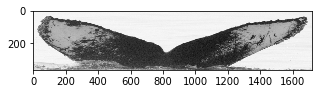

Predicted whaleid for file=[32774657f.jpg], predicted top 5 Ids=['new_whale', 'w_6822dbc', 'w_d405854', 'w_88e4537', 'w_af367c3']
Predicting the whale Id for 32774657f_noisedimage.jpg


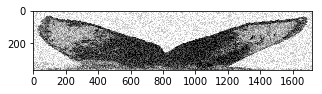

Predicted whaleid for file=[32774657f_noisedimage.jpg], predicted top 5 Ids=['new_whale', 'w_d405854', 'w_af367c3', 'w_0369a5c', 'w_9438119']


In [45]:
predict_indiv_labels('3131fb73b.jpg', extract_InceptionV3, incp_model, 'input/train/')
predict_indiv_labels('3131fb73b_noisedimage.jpg', extract_InceptionV3, incp_model, 'images/')

predict_indiv_labels('32774657f.jpg', extract_InceptionV3, incp_model, 'input/train/')
predict_indiv_labels('32774657f_noisedimage.jpg', extract_InceptionV3, incp_model, 'images/')

## Training Accuracy

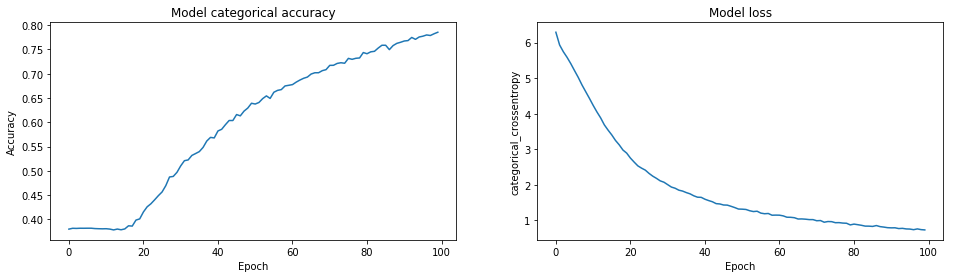

In [46]:
plot_training_history(history)

References

1. Explanation of MAP5 scoring metric - https://www.kaggle.com/pestipeti/explanation-of-map5-scoring-metric
2. Using Bottleneck Features for Multi-Class Classification in Keras and TensorFlow -  https://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html